In [ ]:
#Para usar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy import signal
from astropy.io import fits
rng = np.random.default_rng()

In [ ]:
#Escribimos la ubicación de nuestros archivos .lc para abrirlos
ruta1= '/content/3chan.lc'
ruta2= '/content/3chan2.lc'

In [ ]:
#necesitamos solo las columnas time, rate y rate_err
def plot_light_curvet90(filename,tstart,tstop):
   with fits.open(filename) as hdul:
      information = hdul[1].data
      header1 = hdul[1].header
      T_0=header1['TRIGTIME']
      time=information['TIME']
      rate=information['RATE']
      rate_err=information['ERROR']
      time=time-T_0

      #time=time-(T_0-0.1*T90)

   #creamos nuevos arreglos
   tiempo=[]
   rate2=[]
   rate2_err=[]
   for i in range(0,len(time)):
     if(time[i]>=tstart and time[i]<=tstop):
        tiempo.append(time[i])
        rate2.append(rate[i])
        rate2_err.append(rate_err[i])
   return tiempo,rate2,rate2_err

#CCF y Ajuste Gaussiano


In [ ]:
# Extraemos la información que nos interesa
time, rate, rate_err = plot_light_curvet90(ruta1, -4, 4)

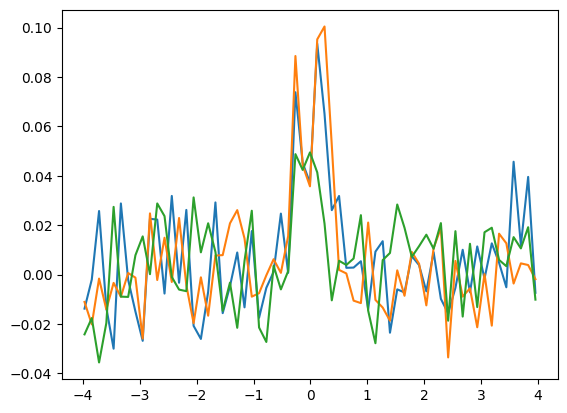

In [ ]:
plt.plot(time,rate)

In [ ]:
rate=np.array(rate)
band1=rate[:, 0]
band1 = [max(0, r) for r in band1]
band2=rate[:, 1]
band2 = [max(0, r) for r in band2]
band3=rate[:, 2]
band3 = [max(0, r) for r in band3]

In [ ]:
#Guardamos en dataframes los datos de las curvas de luz en diferentes
#rangos de energía
df0 = pd.DataFrame()
df0['time']=time
df0['b1']=band1   #15-50keV
df0['b2']=band2   #50-150keV

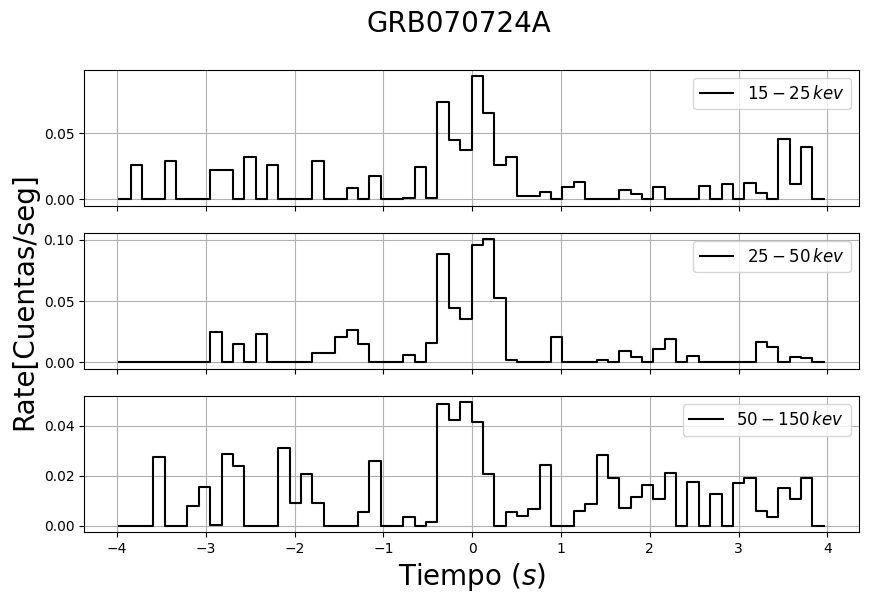

In [ ]:
#Graficamos la curva de luz en diferentes rangos de energía

fig, ax= plt.subplots(3, sharex=True, figsize=(10,6))
fig.suptitle('GRB070724A', fontsize=20)

ax[0].step(time, band1, c='black', label='$15-25\,kev$')
ax[0].legend(loc='upper right',fontsize=12)
#ax[0].set_ylim(0,0.5)
ax[0].grid(True)

ax[1].step(time, band2, c='black', label='$25-50\,kev$')
ax[1].legend(loc='upper right',fontsize=12)
#ax[1].set_ylim(0,0.5)
ax[1].grid(True)

ax[2].step(time, band3, c='black', label='$50-150\,kev$')
ax[2].legend(loc='upper right',fontsize=12)
#ax[1].set_ylim(0,0.5)
ax[2].grid(True)

ax[2].set_xlabel('Tiempo $(s)$', fontsize=20)
ax[1].set_ylabel('Rate[Cuentas/seg]', fontsize=20)

plt.savefig('070724Alighcurve.pdf')
plt.show()

#ax[2].set_ylabel('Cuentas', fontsize=20)
#plt.show()

#plt.savefig('/content/drive/My Drive/JChaconTesis/CCF/ArchivosLC/GRB120804A/GRB120804A_2.png',dpi=150)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ccf_band(d, x, y):
    #Esta función sigue el modelo de la ecuación de Band de CCF
    x = np.array(x)
    y = np.array(y)

    #Limites
    start = max(0, -d)
    end = min(len(x), len(x) - d)

    # Numerador
    numerator = np.sum(x[start:end] * y[start + d:end + d])

    #Denominador
    x_squared_sum = np.sum(x**2)
    y_squared_sum = np.sum(y**2)

    denominator = np.sqrt(x_squared_sum * y_squared_sum)

    # Calcula la CCF
    ccf = numerator / denominator

    return ccf

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def plot_ccf_band_with_fit(x, y, max_d):
    d_values = np.arange(-max_d, max_d + 1)
    ccf_values = np.array([ccf_band(d, x, y) for d in d_values])

    #Valores para una estimación inicial
    n = len(d_values)
    mean = sum(ccf_values*d_values)/n
    sigma = np.sqrt(sum((d_values-mean)**2)/n)
    amplitude = 1/(sigma*np.sqrt(2*np.pi))



    # Ajuste gaussiano
    popt,  pcov = curve_fit(gaussian, d_values, ccf_values, p0=[amplitude, mean, sigma])


    # Obtener los errores estándar de los parámetros
    perr = np.sqrt(np.diag(pcov))

    # Generación de valores ajustados
    fit_values = gaussian(d_values, *popt)

    # Graficar los valores y el ajuste
    plt.figure(figsize=(10, 6))
    plt.plot(d_values*0.128, ccf_values, '*', label='CCF',c='black')
    plt.plot(d_values*0.128, fit_values, label='Ajuste Gaussiano',c='black')
    plt.title('Ajuste Gaussiano 070429B',fontsize='16')
    plt.xlabel('Tiempo de Retardo [s]',fontsize='16')
    plt.ylabel('$CCF_{13}$',fontsize='16')
    plt.legend()
    plt.grid(True)
    plt.savefig('070429Bajuste.pdf')
    plt.show()

    print(f"Media del ajuste: {popt[1]*0.128} ± {perr[1]*0.128}")

    return d_values, ccf_values, popt

max_d = 5 # Valor máximo de desplazamiento

d_values, ccf_values, fit_params = plot_ccf_band_with_fit(band3, band1, max_d)

# Guardar los valores en un archivo
np.savetxt('ccf_values.txt', np.column_stack((d_values, ccf_values)), header='d_values ccf_values')
np.savetxt('fit_params.txt', fit_params, header='amplitude mean sigma')

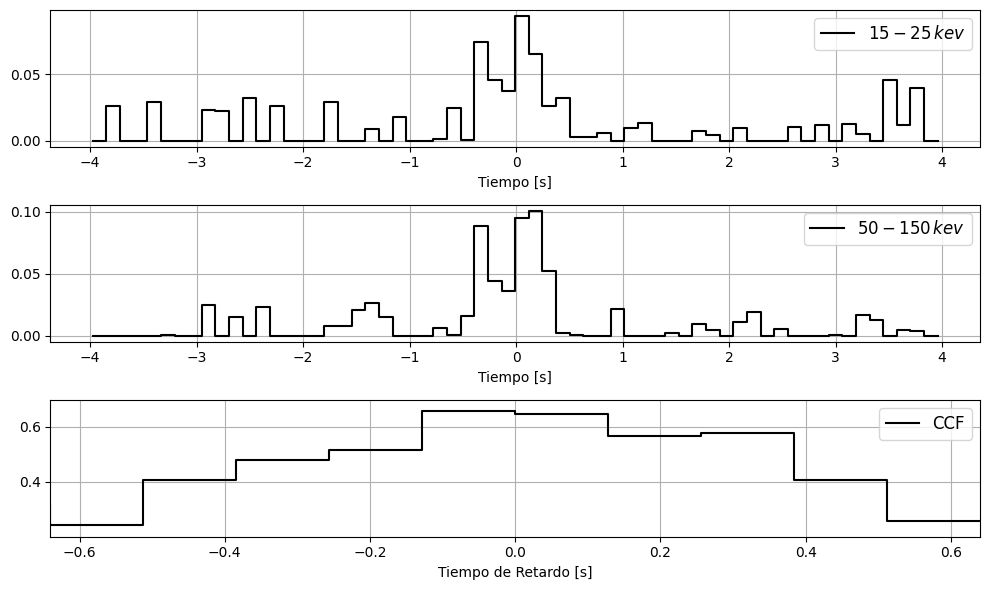

In [ ]:
fig, (ax_orig1, ax_noise1, ax_corr1) = plt.subplots(3, figsize=(10,6))
ax_orig1.step(df0['time'],df0['b1'],c='black', label='$15-25\,kev$')
ax_orig1.legend(loc='upper right',fontsize=12)
ax_orig1.set_xlabel('Tiempo [s]')
ax_orig1.grid(True)


ax_noise1.step(df0['time'],df0['b2'],c='black', label='$50-150\,kev$')
ax_noise1.legend(loc='upper right',fontsize=12)
ax_noise1.set_xlabel('Tiempo [s]')
ax_noise1.grid(True)

ax_corr1.step(d_values*0.128, ccf_values,c='black', label='CCF')
ax_corr1.legend(loc='upper right',fontsize=12)
ax_corr1.set_xlabel('Tiempo de Retardo [s]')
ax_corr1.grid(True)

#ax_noise1.margins(0, 0.1)

ax_corr1.margins(0, 0.1)
fig.tight_layout()
plt.savefig('070429Bccf.pdf')
plt.show()
